In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from utility_functions import SquaredHingeLoss
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_size):
        super(MLPModel, self).__init__()
        self.input_size = input_size
        self.hidden_layers = hidden_layers

        self.linear_model = nn.Linear(input_size, 1) 
        
        self.hidden_size = hidden_size
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(hidden_layers - 1)])
        self.output_layer = nn.Linear(hidden_size, 1)
        
        self.initialize_parameters()

    def initialize_parameters(self):
        for param in self.parameters():
            init.constant_(param, 0)

    def forward(self, x):
        if(self.hidden_layers == 0):
            return self.linear_model(x)
        else:
            x = torch.relu(self.input_layer(x))
            for layer in self.hidden:
                x = torch.relu(layer(x))
            x = self.output_layer(x)
            return x

In [3]:
# normalzie
def normalize_data(tensor):
    mean = torch.mean(tensor, dim=0)
    std = torch.std(tensor, dim=0)
    normalized_tensor = (tensor - mean) / std
    return normalized_tensor

In [4]:
# learn model
def mlp_training(inputs_df, outputs_df, hidden_layers, hidden_size, chosen_feature, f_engineer, normalize, batch_size, margin, n_ites, lr, patience, verbose, epoch_step):
    # inputs
    inputs = inputs_df[chosen_feature].to_numpy()

    # feature engineering
    for i in range(len(f_engineer)):
        inputs[:, i] = f_engineer[i](inputs[:, i])
    inputs = torch.Tensor(inputs)

    # normalize input
    if normalize == 1:
        inputs = normalize_data(inputs)

    # outputs
    targets_low  = torch.Tensor(outputs_df['min.log.lambda'].to_numpy().reshape(-1,1))
    targets_high = torch.Tensor(outputs_df['max.log.lambda'].to_numpy().reshape(-1,1))
    outputs = torch.cat((targets_low, targets_high), dim=1)

    # prepare training dataset
    dataset    = TensorDataset(inputs, outputs)
    dataloader = DataLoader(dataset, batch_size, shuffle=False)

    # Instantiate model, loss function and optimizer
    model = MLPModel(inputs.shape[1], hidden_layers, hidden_size)
    criterion = SquaredHingeLoss(margin)
    optimizer = optim.Adam(model.parameters(), lr)

    # Initialize early stopping parameters
    best_loss = float('inf')
    num_bad_epochs = 0

    # Training loop
    for epoch in range(n_ites):
        model.train()
        for features, labels in dataloader:
            optimizer.zero_grad()
            loss = criterion(model(features), labels)
            loss.backward()
            optimizer.step()

        # Calculate validation loss
        model.eval()
        val_loss = criterion(model(inputs), outputs)
        if verbose==1:
            if epoch % epoch_step == 0:
                print(f"{epoch}, loss: {val_loss}")

        # Check for early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            num_bad_epochs = 0
        else:
            num_bad_epochs += 1
            if num_bad_epochs >= patience:
                if verbose==1:
                    print(f"Stopping early at epoch {epoch}, loss: {val_loss}")
                break
        
    return model, val_loss.item()

In [6]:
def plot_solution(x, y_start, y_end, sol):
    plt.scatter(x, y_start, color='r', s=2, label='min.log.lambda')
    plt.scatter(x, y_end,   color='b', s=2, label='max.log.lambda')
    plt.plot(x, sol)
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
# PATHs (edit these paths depending on dataset)
dataset = 'detailed'

# training data
fold_path = 'training_data/' + dataset + '/folds.csv'
inputs_path = 'training_data/' + dataset + '/inputs.csv'
outputs_path = 'training_data/' + dataset + '/outputs.csv'

# raw dfs
fold = 1
fold_df = pd.read_csv(fold_path)
inputs_df = pd.read_csv(inputs_path)
outputs_df = pd.read_csv(outputs_path)

# fold dfs
inputs_df = inputs_df[inputs_df['sequenceID'].isin(fold_df[fold_df['fold'] == 1]['sequenceID'])]
outputs_df = outputs_df[outputs_df['sequenceID'].isin(fold_df[fold_df['fold'] == 1]['sequenceID'])]

# feature engineering transformation
loglog = lambda x: np.log(np.log(x))

In [8]:
chosen_feature = ['length']
f_engineering  = [loglog]

In [9]:
x = inputs_df[chosen_feature].to_numpy()
x = loglog(x)
y_start = outputs_df['min.log.lambda'].to_numpy()
y_end   = outputs_df['max.log.lambda'].to_numpy()

0, loss: 0.4525125026702881
100, loss: 0.40050357580184937
200, loss: 0.3673129975795746
300, loss: 0.34437403082847595
400, loss: 0.3301416337490082
500, loss: 0.3209601044654846
600, loss: 0.3149397373199463
700, loss: 0.3110441267490387
800, loss: 0.3085189461708069
900, loss: 0.30683594942092896


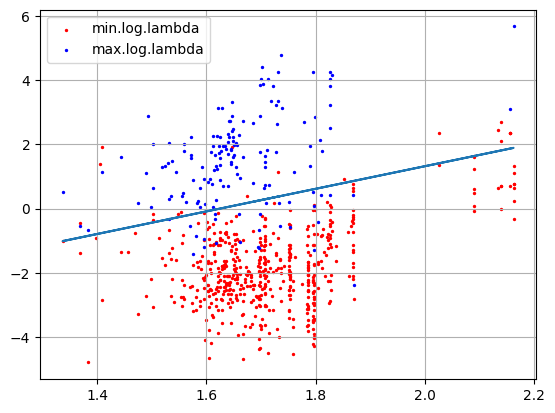

In [10]:
model, _ = mlp_training(
    inputs_df = inputs_df, 
    outputs_df = outputs_df, 
    hidden_layers = 0, 
    hidden_size = 100, 
    chosen_feature = ['length'], 
    f_engineer = [loglog],
    normalize = 0,
    batch_size = 1,
    margin = 1,
    n_ites = 1000,
    lr = 0.001,
    patience = 100,
    verbose = 1,
    epoch_step = 100)
sol = model(torch.Tensor(x)).detach().numpy()
plot_solution(x, y_start, y_end, sol)